# Выбор локации для скважины

### Задача

---

Некоторая нефтедобывающая компания решает, где бурить новую скважину. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесет наибольшую прибыль. С помощью этой модели нужно оценить возможную прибыль и риски.

При решении задачи нужно соблюдать следующие условия:
- использовать линейную регрессию, так как она хорошо интерпретируема и предсказуема
- при разведке региона исследуют 500 точек, из которых с помощью модели выбирают 200 лучших для разработки
- бюджет на разработку скважин в регионе - 10 млрд рублей
- считаем, что доход с 1 барреля сырья составляет 450 рублей
- нужны лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них нужно выбрать регион с наибольшей средней прибылью

### Данные

---

Нам предоставлены пробы нефти в трех регионах: в каждом 10 000 месторождений, где измерили качество нефти и объем её запасов. Данные синтетические.

Описание данных:
- `id` - идентификатор месторождения
- `f0`, `f1`, `f2` - некоторые показатели качества нефти
- `product` - объем запасов нефти в тыс. баррелей

### План проекта:

---

1. Предобработка данных.
    - Изучение датасетов, подготовка данных к обучению модели.
2. Обучение моделей.
    - Для каждого региона: обучить линейную регрессию на обучающей выборке, на валидационной проверить метрику RMSE и посчитать средний объем предсказанной скважины, сравнить со средней моделью.
3. Расчёт прибыли и рисков.
    - Методом бутстрепа выбрать 500 скважин для каждого региона, среди которых взять 200 скважин с наибольшими предсказанными объемами сырья. По известным истинным объемам вычислить прибыль. Повторить процесс 1000 раз, построить распределение прибыли и посчитать статистики: среднее значение и 95%-й доверительный интервал. Также посчитать вероятность убытков как долю значений прибыли меньше нуля.


---

## Предобработка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
RANDOM_STATE = 42

### Изучение датасетов

In [3]:
df0 = pd.read_csv('../datasets/geo_data_0.csv')
df1 = pd.read_csv('../datasets/geo_data_1.csv')
df2 = pd.read_csv('../datasets/geo_data_2.csv')

In [4]:
# выводит общую информацию о датасете
def general_info(data):
    display(data.head())
    print(data.info())
    print('\nЯвных дубликатов:', data.duplicated().sum())
    print('\nДубликатов id:', data['id'].duplicated().sum())
    
    data.hist(figsize=(8, 6), rwidth=0.9)
    plt.show()
    
    display(data.describe())
    
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(data.corr(numeric_only=True), annot=True, fmt='.1f', annot_kws={"fontsize": 12}, ax=ax)
    plt.show()

Информация по датасету geo_data_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Явных дубликатов: 0

Дубликатов id: 10


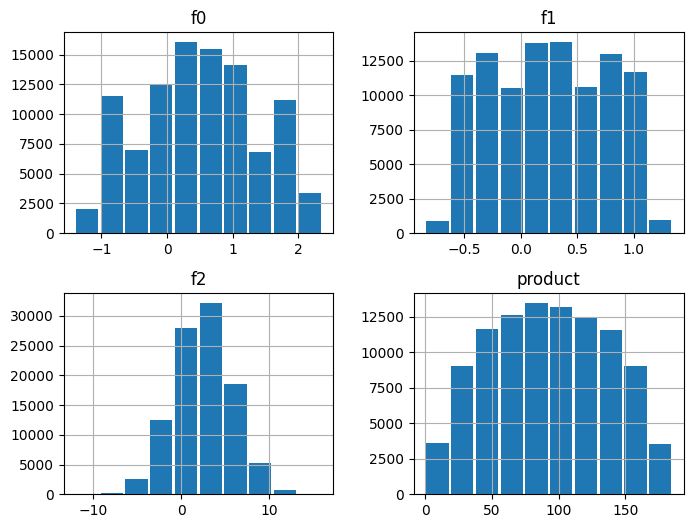

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


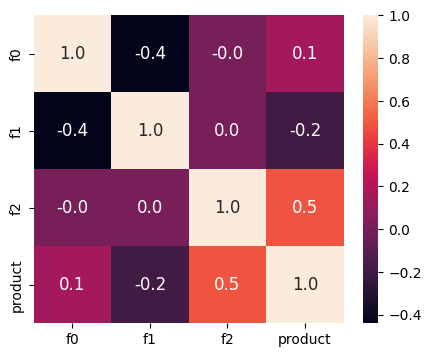

Информация по датасету geo_data_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Явных дубликатов: 0

Дубликатов id: 4


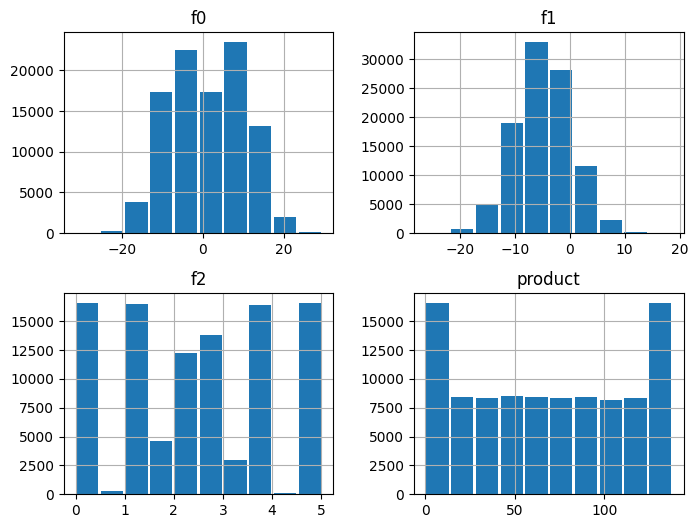

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


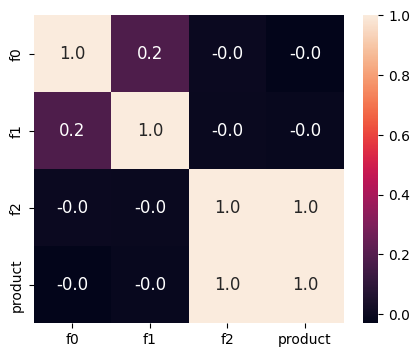

Информация по датасету geo_data_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Явных дубликатов: 0

Дубликатов id: 4


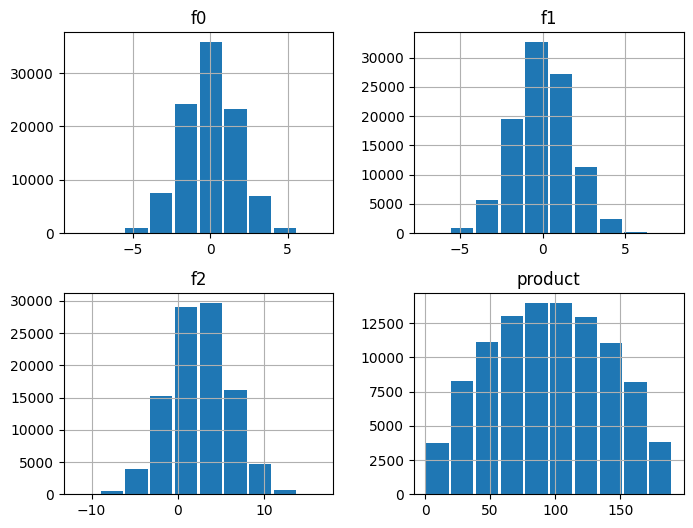

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


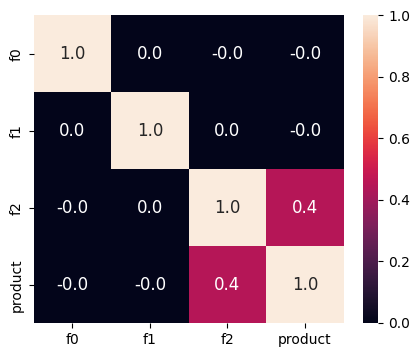

In [5]:
for i, df in enumerate((df0, df1, df2)):
    print(f"Информация по датасету geo_data_{i}")
    general_info(df)

**Промежуточный вывод:**

Каждый датасет содержит 10 000 объектов и 5 признаков, из которых `product` - целевой.

Пропусков и явных дубликатов нет. Есть дубликаты id, однако значения признаков `f` и объема `product` у них разное, поэтому было решено оставить эти объекты. Дублирование id могло произойти случайно.

Коллинеарность в признаках не наблюдается, но можно заметить, что на целевой признак больше всего влияет признак `f2` для всех регионов. Также заметим, что вид распределений признаков по регионам различается.

Для подготовки данных к обучению нужно:

- удалить незначимый признак `id` - идентификатор скважины;
- разделить данные на обучающую и валидационную выборки в соотношении 75:25;
- отмасштабировать признаки.

### Подготовка данных к обучению

Удалим незначимый признак `id`.

In [6]:
for df in (df0, df1, df2):
    df.drop('id', axis=1, inplace=True)

Разделим данные на обучающую и валидационную выборки в соотношении 75:25.

In [7]:
y0, y1, y2 = df0['product'], df1['product'], df2['product']
X0, X1, X2 = df0.drop('product', axis=1), df1.drop('product', axis=1), df2.drop('product', axis=1)

X0_train, X0_valid, y0_train, y0_valid = train_test_split(
    X0, y0, test_size=0.25, random_state=RANDOM_STATE)
X1_train, X1_valid, y1_train, y1_valid = train_test_split(
    X1, y1, test_size=0.25, random_state=RANDOM_STATE)
X2_train, X2_valid, y2_train, y2_valid = train_test_split(
    X2, y2, test_size=0.25, random_state=RANDOM_STATE)

In [8]:
print('Размеры выборок:')
print('train -', len(X0_train)) if len(X0_train)==len(X1_train)==len(X2_train) else print("train - разные")
print('valid -', len(X0_valid)) if len(X0_valid)==len(X1_valid)==len(X2_valid) else print("valid - разные")

Размеры выборок:
train - 75000
valid - 25000


Проведем масштабирование признаков

In [9]:
scaler = StandardScaler()
X0_train = scaler.fit_transform(X0_train)
X0_valid = scaler.transform(X0_valid)

X1_train = scaler.fit_transform(X1_train)
X1_valid = scaler.transform(X1_valid)

X2_train = scaler.fit_transform(X2_train)
X2_valid = scaler.transform(X2_valid)

## Обучение и проверка модели

Обучим модель линейной регрессии для каждого региона и сделаем предсказания на валидационных выборках.

In [10]:
model0 = LinearRegression().fit(X0_train, y0_train)
pred0_valid = pd.Series(model0.predict(X0_valid))
y0_valid.reset_index(drop=True, inplace=True)

model1 = LinearRegression().fit(X1_train, y1_train)
pred1_valid = pd.Series(model1.predict(X1_valid))
y1_valid.reset_index(drop=True, inplace=True)

model2 = LinearRegression().fit(X2_train, y2_train)
pred2_valid = pd.Series(model2.predict(X2_valid))
y2_valid.reset_index(drop=True, inplace=True)

Найдем средний предсказанный запас сырья в скважине и RMSE модели для каждого региона.

In [11]:
for i, (pred_valid, y_valid) in enumerate([(pred0_valid, y0_valid),
                                                (pred1_valid, y1_valid),
                                                (pred2_valid, y2_valid)]):
    print(f"---------{i+1}-й регион---------")
    print(f"Средний запас предсказанного сырья: {pred_valid.mean():.2f} тыс. баррелей")
    print(f"RMSE модели: {mean_squared_error(y_valid, pred_valid) ** 0.5:.2f} тыс. баррелей")
    print()

---------1-й регион---------
Средний запас предсказанного сырья: 92.40 тыс. баррелей
RMSE модели: 37.76 тыс. баррелей

---------2-й регион---------
Средний запас предсказанного сырья: 68.71 тыс. баррелей
RMSE модели: 0.89 тыс. баррелей

---------3-й регион---------
Средний запас предсказанного сырья: 94.77 тыс. баррелей
RMSE модели: 40.15 тыс. баррелей



Сравним со средней моделью.

In [12]:
for i, (y_train, y_valid) in enumerate([(y0_train, y0_valid),
                                        (y1_train, y1_valid),
                                        (y2_train, y2_valid)]):
    
    predicted_const = [y_train.mean()]*len(y_valid)
    print(f"---------{i+1}-й регион---------")
    print(f"RMSE средней модели: {mean_squared_error(y_valid, predicted_const) ** 0.5:.2f} тыс. баррелей")
    print()

---------1-й регион---------
RMSE средней модели: 44.28 тыс. баррелей

---------2-й регион---------
RMSE средней модели: 45.94 тыс. баррелей

---------3-й регион---------
RMSE средней модели: 44.78 тыс. баррелей



**Промежуточный вывод:**

Во 2-м регионе средний объем сырья в скважине меньше, чем в других регионах. Однако модель линейной регрессии во 2-м регионе оказалась самой качественной по RMSE. В 1-м и 3-м регионах качество моделей близко к средней модели.

## Расчёт прибыли и рисков

In [13]:
SAMPLE_SIZE = 500
NUMBER_OF_SITES = 200
BUDGET = 10e9            # rubles
PROFIT_PER_UNIT = 450e3  # rubles / kbbl

Посчитаем, сколько должно быть сырья в скважине, чтобы выйти в ноль.

In [14]:
product_threshold = BUDGET / NUMBER_OF_SITES / PROFIT_PER_UNIT

print(f"Для безубыточной разработки новой скважины объём сырья должен составлять {product_threshold:.2f} килобаррель.")

Для безубыточной разработки новой скважины объём сырья должен составлять 111.11 килобаррель.


Средний запас сырья по регионам меньше 111.11 тыс. баррелей (см. результаты выше). Это значит, что если мы будем случайно выбирать 200 скважин для разработки, то рискуем оказаться в минусе. Поэтому следует изучить больше 200 скважин (а именно 500 в данной задаче), из которых выбрать 200 с максимальным предсказанным объемом сырья.

Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели.

In [15]:
def profit_calc(actual, predicted):
    sum_product = actual[predicted.sort_values(ascending=False).head(NUMBER_OF_SITES).index].sum()
    return sum_product * PROFIT_PER_UNIT - BUDGET

Построим для каждого региона методом бутстрепа распределение случайной величины - прибыли от добычи нефти на 200 скважинах.

---------1-й регион---------


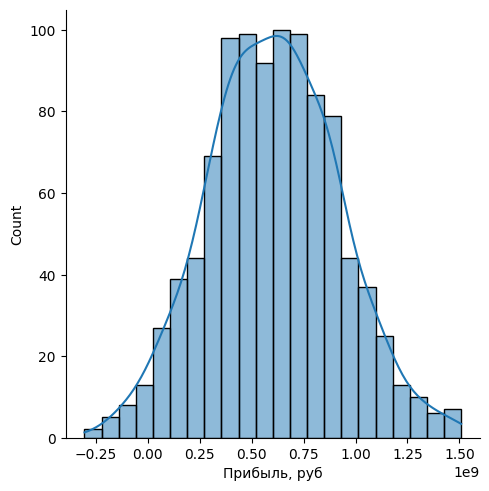

Средняя прибыль: 606122631.53 руб
95%-й доверительный интервал: [10089412.00, 1246370980.56]
Вероятность убытков: 2.5%

---------2-й регион---------


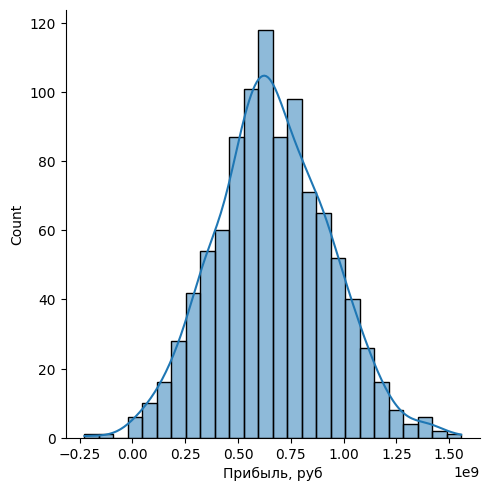

Средняя прибыль: 662413205.01 руб
95%-й доверительный интервал: [148800010.97, 1186977426.07]
Вероятность убытков: 0.3%

---------3-й регион---------


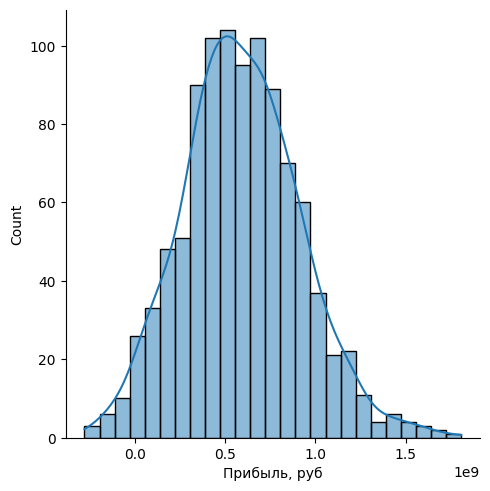

Средняя прибыль: 592052020.95 руб
95%-й доверительный интервал: [2464800.77, 1254827360.51]
Вероятность убытков: 2.5%



In [16]:
state = RandomState(RANDOM_STATE)

for i, (y_valid, pred_valid) in enumerate([(y0_valid, pred0_valid),
                                           (y1_valid, pred1_valid),
                                           (y2_valid, pred2_valid)]):
    boot_profit = []

    for _ in range(1000):
        actual = y_valid.sample(SAMPLE_SIZE, replace=True, random_state=state)
        predicted = pred_valid[actual.index]
        boot_profit.append(profit_calc(actual, predicted))
        
    boot_profit = pd.Series(boot_profit)

    print(f"---------{i+1}-й регион---------")
    sns.displot(boot_profit, kde=True).set_xlabels("Прибыль, руб")
    plt.show()
    print(f"Средняя прибыль: {boot_profit.mean():.2f} руб")
    print(f"95%-й доверительный интервал: [{boot_profit.quantile(0.025):.2f}, {boot_profit.quantile(0.975):.2f}]")
    print(f"Вероятность убытков: {(boot_profit < 0).sum()/len(boot_profit):.1%}")
    print()

**Промежуточный вывод:** 

Самая низкая вероятность убытков и самая высокая средняя прибыль во втором регионе, поэтому для разработки скважин предлагается выбрать его.

## Вывод

В ходе работы над проектом были исследованы данные месторождений нефти из трех регионов.

Для каждого региона мы построили модель линейной регрессии для предсказания объема нефти в скважине по ее характеристикам. Качество моделей для 1-го и 3-го регионов оказались сравнимы со случайной моделью - $\text{RMSE}\approx$ 40 тыс. баррелей, в то время как качество модели для 2-го региона составило меньше 1 тыс. баррелей.

Затем мы смоделировали случайный процесс разведки и отбора скважин: случайно выбрали для каждого региона 500 скважин, по предсказанным значениям объема выбрали 200 лучших, а по известным значениям объема нашли выручку. Таким образом, методом бутстрепа мы построили распределение прибыли на каждом регионе, нашли среднее значение, 95%-й доверительный интревал и вероятность убытков.

В итоге мы выбрали регион с наибольшей средней прибылью и наименьшими рисками - **второй регион** со средней прибылью ~660 млн руб, и вероятностью убытков 0.3%.